In [1]:
%matplotlib inline
import pandas as pd
#import pandas.io.data as web
from pandas_datareader import data as web
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import time

/Users/davidalbertomartinvela/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# EDA

In [2]:
symbols = ['GME', 'BB', 'NOK', 'AMC']

In [3]:
# year, month, and day.
start = dt.datetime(2014, 12, 1)
end = dt.datetime.now()

volume = []
closes = []
for symbol in symbols:
    print(symbol)
    vdata = web.DataReader(symbol, 'yahoo', start, end)
    cdata = vdata[['Close']]
    closes.append(cdata)
    vdata = vdata[['Volume']]
    volume.append(vdata)
    
volume = pd.concat(volume, axis = 1).dropna()
volume.columns = symbols
closes = pd.concat(closes, axis = 1).dropna()
closes.columns = symbols

GME
BB
NOK
AMC


In [4]:
volume.head()

,GME,BB,NOK,AMC
Date,,,,
2014-12-01,6784300.0,6582100,10933900.0,381900.0
2014-12-02,3673100.0,8537500,17353400.0,166300.0
2014-12-03,4531800.0,6241300,24702200.0,183700.0
2014-12-04,3148900.0,11506400,8797200.0,198800.0
2014-12-05,2817300.0,6681100,16942300.0,296200.0


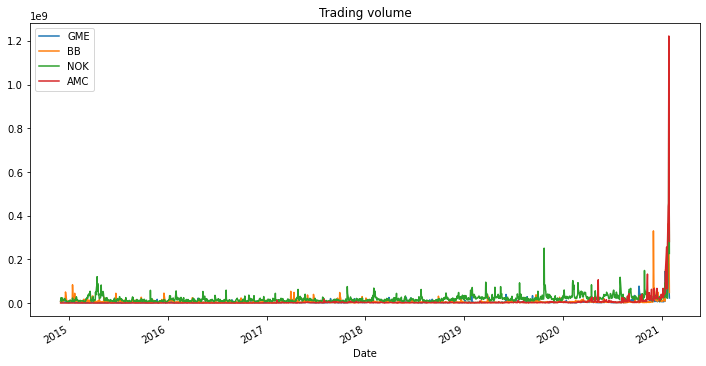

In [5]:
volume.plot(title = "Trading volume",figsize=(12, 6))
plt.savefig("figures/trading_volume.pdf")
plt.show()

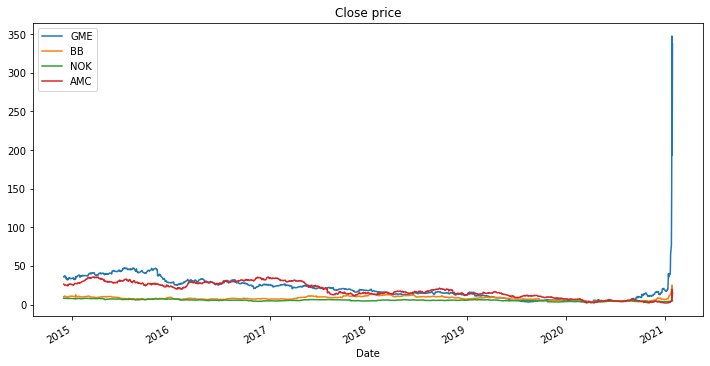

In [6]:
closes.plot(title = "Close price", figsize=(12, 6))
plt.savefig("figures/close_price.pdf")
plt.show()

In [7]:
print(volume.describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &           GME &            BB &           NOK &           AMC \\
\midrule
count &  1.552000e+03 &  1.552000e+03 &  1.552000e+03 &  1.552000e+03 \\
mean  &  4.721159e+06 &  7.565979e+06 &  2.102421e+07 &  5.649391e+06 \\
std   &  1.081986e+07 &  1.973506e+07 &  3.801423e+07 &  4.063877e+07 \\
min   &  7.461000e+05 &  1.054900e+06 &  1.425600e+06 &  6.520000e+04 \\
25\%   &  1.954750e+06 &  3.130825e+06 &  1.032080e+07 &  3.055500e+05 \\
50\%   &  2.755900e+06 &  4.372050e+06 &  1.548300e+07 &  1.442800e+06 \\
75\%   &  4.327925e+06 &  6.778200e+06 &  2.347005e+07 &  2.801925e+06 \\
max   &  1.967843e+08 &  3.722226e+08 &  1.123003e+09 &  1.222342e+09 \\
\bottomrule
\end{tabular}



In [8]:
print("Skewness: %f" % volume['GME'].skew())
print("Kurtosis: %f" % volume['GME'].kurt())

Skewness: 11.982884
Kurtosis: 175.822296


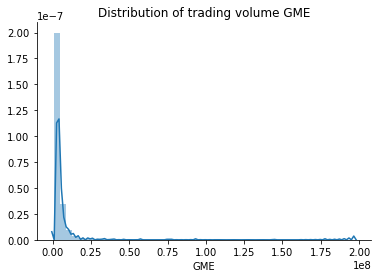

In [9]:
sns_plot = sns.distplot(volume['GME'])
plt.title("Distribution of trading volume GME")
sns.despine()
sns_plot.get_figure().savefig("figures/distribution_trading_volume_GME.pdf") 

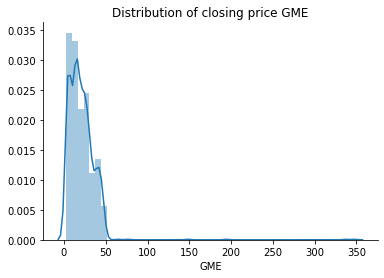

In [10]:
sns_plot = sns.distplot(closes['GME'])
plt.title("Distribution of closing price GME")
sns.despine()
sns_plot.get_figure().savefig("figures/distribution_closing_price_GME.pdf") 

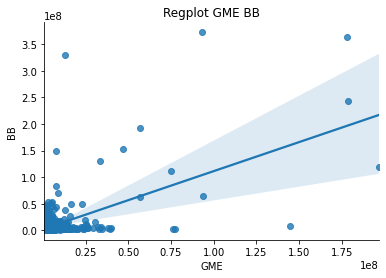

In [11]:
sns_plot = sns.regplot(x="GME", y="BB", data=volume)
plt.title("Regplot GME BB")
sns.despine();
sns_plot.get_figure().savefig("figures/regplot_GME_BB.pdf") 

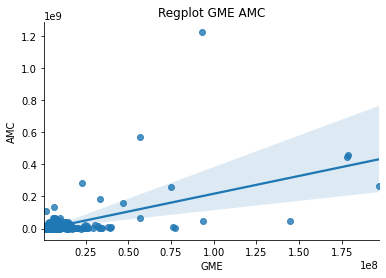

In [12]:
sns_plot = sns.regplot(x="GME", y="AMC", data=volume)
plt.title("Regplot GME AMC")
sns.despine();
sns_plot.get_figure().savefig("figures/regplot_GME_AMC.pdf") 

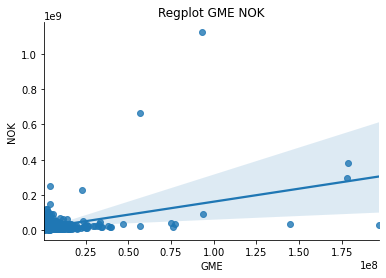

In [13]:
sns_plot = sns.regplot(x="GME", y="NOK", data=volume)
plt.title("Regplot GME NOK")
sns.despine();
sns_plot.get_figure().savefig("figures/regplot_GME_NOK.pdf") 

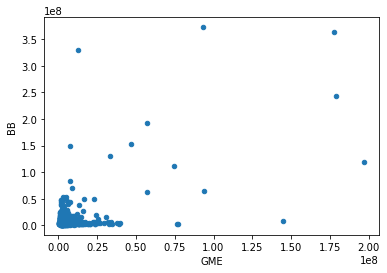

In [14]:
volume.plot.scatter('GME','BB')
plt.savefig("figures/GME_BB.pdf")
plt.show()

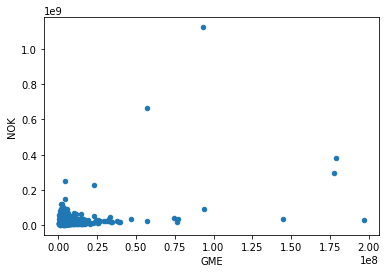

In [15]:
volume.plot.scatter('GME','NOK')
plt.savefig("figures/GME_NOK.pdf")
plt.show()

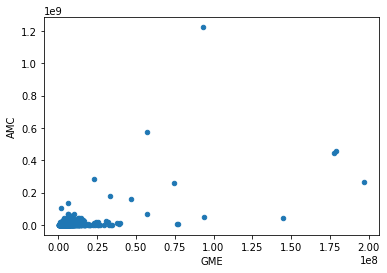

In [30]:
volume.plot.scatter('GME','AMC')
plt.savefig("figures/GME_AMC.pdf")
plt.show()

In [17]:
GME_BB_volume = volume.iloc[:, 0:2]

In [18]:
GME_BB_volume.head()

,GME,BB
Date,,
2014-12-01,6784300.0,6582100
2014-12-02,3673100.0,8537500
2014-12-03,4531800.0,6241300
2014-12-04,3148900.0,11506400
2014-12-05,2817300.0,6681100


# Models to use

## IsolationForest (Univariate Anomaly Detection)

In [19]:
from sklearn.ensemble import IsolationForest

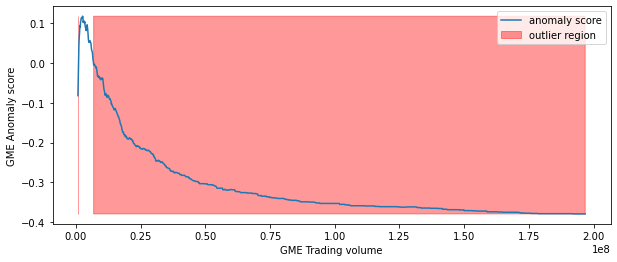

In [20]:
#GME volume
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(volume['GME'].values.reshape(-1, 1))
xx = np.linspace(volume['GME'].min(), volume['GME'].max(), len(volume)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('GME Anomaly score')
plt.xlabel('GME Trading volume')
plt.savefig("figures/if_trading_GME.pdf")
plt.show();

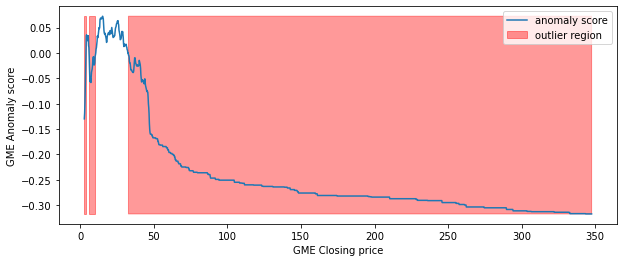

In [21]:
# GME closing price
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(closes['GME'].values.reshape(-1, 1))
xx = np.linspace(closes['GME'].min(), closes['GME'].max(), len(closes)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('GME Anomaly score')
plt.xlabel('GME Closing price')
plt.savefig("figures/if_closing_GME.pdf")
plt.show();

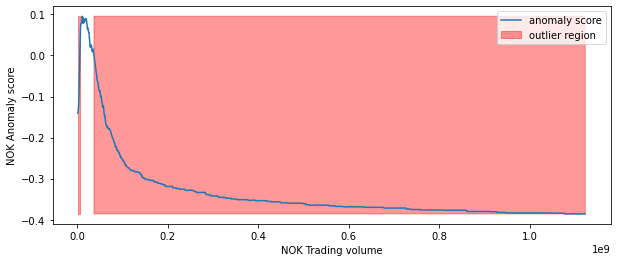

In [22]:
# Nokia volume
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(volume['NOK'].values.reshape(-1, 1))
xx = np.linspace(volume['NOK'].min(), volume['NOK'].max(), len(volume)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('NOK Anomaly score')
plt.xlabel('NOK Trading volume')
plt.savefig("figures/if_trading_NOK.pdf")
plt.show();

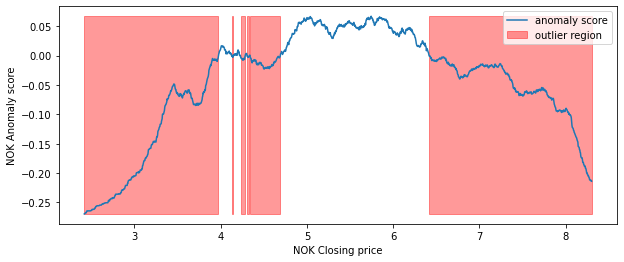

In [23]:
# Nokia closing price
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(closes['NOK'].values.reshape(-1, 1))
xx = np.linspace(closes['NOK'].min(), closes['NOK'].max(), len(closes)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('NOK Anomaly score')
plt.xlabel('NOK Closing price')
plt.savefig("figures/if_closing_NOK.pdf")
plt.show();

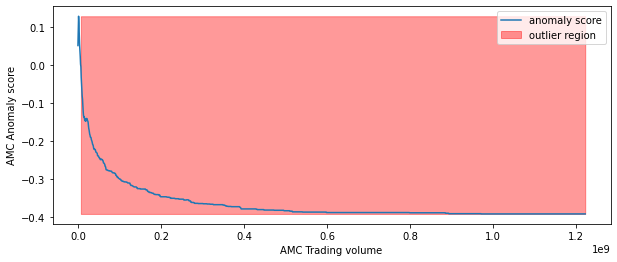

In [24]:
# AMC volume
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(volume['AMC'].values.reshape(-1, 1))
xx = np.linspace(volume['AMC'].min(), volume['AMC'].max(), len(volume)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('AMC Anomaly score')
plt.xlabel('AMC Trading volume')
plt.savefig("figures/if_trading_AMC.pdf")
plt.show();

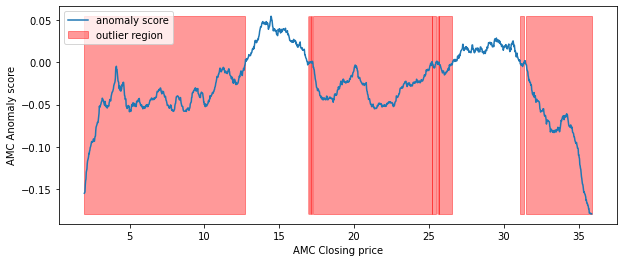

In [25]:
# AMC closing price
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(closes['AMC'].values.reshape(-1, 1))
xx = np.linspace(closes['AMC'].min(), closes['AMC'].max(), len(closes)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('AMC Anomaly score')
plt.xlabel('AMC Closing price')
plt.savefig("figures/if_closing_AMC.pdf")
plt.show();

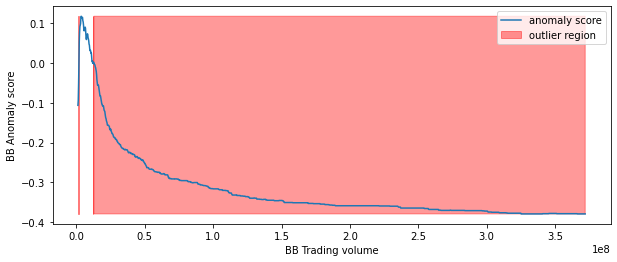

In [26]:
# BB volume
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(volume['BB'].values.reshape(-1, 1))
xx = np.linspace(volume['BB'].min(), volume['BB'].max(), len(volume)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('BB Anomaly score')
plt.xlabel('BB Trading volume')
plt.savefig("figures/if_trading_BB.pdf")
plt.show();

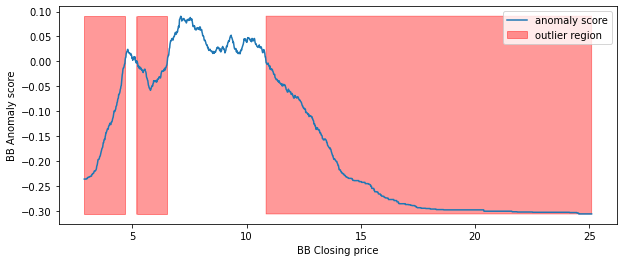

In [27]:
# BB closing price
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(closes['BB'].values.reshape(-1, 1))
xx = np.linspace(closes['BB'].min(), closes['BB'].max(), len(closes)).reshape(-1,1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('BB Anomaly score')
plt.xlabel('BB Closing price')
plt.savefig("figures/if_closing_BB.pdf")
plt.show();

## PyOD

In [28]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
GME_BB_volume[['GME','BB']] = scaler.fit_transform(GME_BB_volume[['GME','BB']])
GME_BB_volume[['GME','BB']].head()

,GME,BB
Date,,
2014-12-01,0.030801,0.014891
2014-12-02,0.014931,0.020160
2014-12-03,0.019311,0.013973
2014-12-04,0.012257,0.028158
2014-12-05,0.010565,0.015158


In [ ]:
X1 = GME_BB_volume['GME'].values.reshape(-1,1)
X2 = GME_BB_volume['BB'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [ ]:
# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [ ]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.01
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

In [ ]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(25, 15))
    
    # copy of dataframe
    dfx = GME_BB_volume
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['GME'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['BB'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['GME'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['BB'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    subplot = plt.subplot(3, 4, i + 1)
    # fill blue map colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    b = subplot.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    c = subplot.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
    subplot.axis('tight')  
    
    subplot.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')
    subplot.set_xlabel("%d. %s" % (i + 1, clf_name))
    subplot.set_xlim((0, 1))
    subplot.set_ylim((0, 1))
plt.show()